In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Input, Flatten, Dropout
from keras import metrics
from keras.metrics import TopKCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
data = tf.keras.datasets.cifar10

In [ ]:
(X_tr, y_tr), (X_t, y_t) = data.load_data()

In [ ]:
print(f"Total samples in dataset = {len(y_tr) + len(y_t)}")
print(f"Total samples in training = {len(y_tr)}")
print(f"Total samples in testing = {len(y_t)}")

Total samples in dataset = 60000
Total samples in training = 50000
Total samples in testing = 10000


In [ ]:
print(f"Shape of images = {X_tr[0].shape}")

Shape of images = (32, 32, 3)


[0] 0


Text(0.5, 1.0, 'Image number 32023 -> airplane')

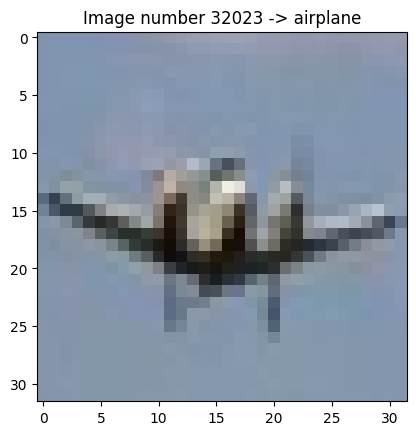

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, len(y_tr))
image, val = X_tr[idx], y_tr[idx]
plt.imshow(image)
print(val, val[0])
s = f"Image number {idx+1} -> " + labels[int(val[0])]
plt.title(s)

Text(0.5, 1.0, 'X_train distribution')

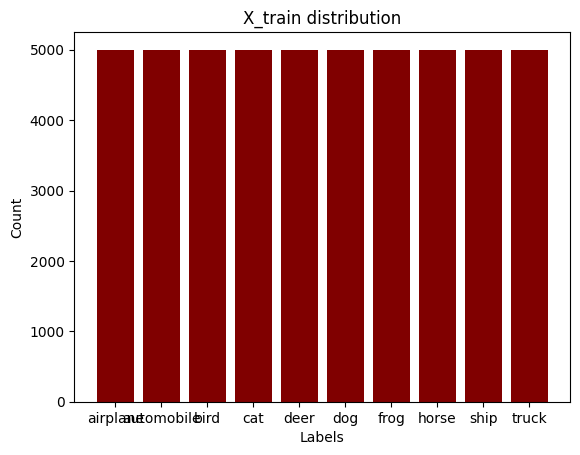

In [ ]:
count = np.zeros(10)
for _ in range(len(y_tr)):
  count[y_tr[_][0]] += 1
plt.bar(labels, count, color= 'maroon')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('X_train distribution')

In [ ]:
def preprocess_pipeline(X, y):
  print(f"X_train shape = {X.shape} | y_train shape = {y.shape}")
  X_ret = X / 255
  encoder = OneHotEncoder()
  y_ret = encoder.fit_transform(y)
  print("Categories One-Hot Encoder: ", encoder.categories_)
  X_ret, y_ret = shuffle(X_ret, y_ret)
  print(f"After One-Hot Encoding: X_train shape = {X_ret.shape} | y_train shape = {y_ret.shape}")
  return X_ret, y_ret.toarray(), encoder

In [ ]:
enc = None
X_train, y_train, enc = preprocess_pipeline(X_tr, y_tr)

X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 1)
Categories One-Hot Encoder:  [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]
After One-Hot Encoding: X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 10)


**Configs**

In [ ]:
CONFIGS = {
    'Num_Classes' : 10,
    'Class_Names' : labels,
    'Batch_Size' : 256,
    'Epochs' : 60,
    'INIT_LR' : 1e-3,
    'Max_Iters' : 100,
    'Callbacks' : None,
    'Validation_Split' : 0.15,
    'Test_Split' : 0.2,
    'Loss' : 'CategoricalCrossEntropy',
    'METRICS' : ['accuracy', TopKCategoricalAccuracy(k=3,name='top_3_acc')]
}

**Utilities**

In [ ]:
def lr_scheduler(epoch, lr):
    new_lr = lr * (1 - (epoch / float(100))**1.5)
    # print(f"New Learning Rate: {new_lr}")
    return new_lr

In [ ]:
class CustomConv(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, activation = 'relu', padding='same'):
    super(CustomConv, self).__init__(name = 'CustomConv2D')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = activation,
        strides = n_strides,
        padding = padding)
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):
    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [ ]:
class Residual(Layer):
  def __init__(self, n_filters, kernel, n_strides = 1):
    super(Residual, self).__init__(name = "ResidualBlock")

    self.jump = (n_strides != 1)

    self.conv1 = CustomConv(n_filters = n_filters, kernel_size = kernel, n_strides = n_strides)
    self.conv2 = CustomConv(n_filters = n_filters, kernel_size = kernel, n_strides = 1)

    self.activation = Activation('relu')

    if self.jump:
      self.conv3 = CustomConv(n_filters = n_filters, kernel_size = 1, n_strides = n_strides)

  def call(self, input, training= True):
    x = self.conv1(input, training)
    x = self.conv2(x, training)

    if self.jump:
      x_added = self.conv3(input, training)
      x_added = Add()([x, x_added])
    else:
      x_added = Add()([x, input])

    return self.activation(x_added)

In [ ]:
class resnet_34(Model):
  def __init__(self,):
    super(resnet_34, self).__init__(name= "ResNet_34")

    self.conv_1 = CustomConv(64, 7, 2)
    self.max_pool = MaxPooling2D(3, 2)

    self.conv_1_1 = Residual(64, 3)
    self.conv_1_2 = Residual(64, 3)
    self.conv_1_3 = Residual(64, 3)

    self.conv_2_1 = Residual(128, 3, 2)
    self.conv_2_2 = Residual(128, 3)
    self.conv_2_3 = Residual(128, 3)
    self.conv_2_4 = Residual(128, 3)

    self.conv_3_1 = Residual(256, 3, 2)
    self.conv_3_2 = Residual(256, 3)
    self.conv_3_3 = Residual(256, 3)
    self.conv_3_4 = Residual(256, 3)
    self.conv_3_5 = Residual(256, 3)
    self.conv_3_6 = Residual(256, 3)

    self.conv_4_1 = Residual(512, 3, 2)
    self.conv_4_2 = Residual(512, 3)
    self.conv_4_3 = Residual(512, 3)

    self.avg_pool = GlobalAveragePooling2D()
    self.fc = Dense(CONFIGS['Num_Classes'], activation='softmax')

  def call(self, x, training= True):
    x = self.conv_1(x, training)
    x = self.max_pool(x)

    x = self.conv_1_1(x, training)
    x = self.conv_1_2(x, training)
    x = self.conv_1_3(x, training)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    x = self.conv_2_4(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    x = self.conv_3_5(x, training)
    x = self.conv_3_6(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)

    x = self.avg_pool(x)

    return self.fc(x)

**Training**

In [ ]:
# @title Default title text
# def get_model(X, y):
#   x_shape = X[0].shape
#   y_shape = y[0].shape
#   print(f"Train Shape = {X_train[0].shape} and Label Shape = {y_train[0].shape}")
#   model = keras.Sequential([
#                             Conv2D(32, kernel_size= (3, 3), input_shape = x_shape, activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             Conv2D(32, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             MaxPooling2D(pool_size= (2, 2)),
#                             Dropout(0.15),
#                             Conv2D(64, kernel_size= (3, 4), activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             Conv2D(64, kernel_size= (4, 3), activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             MaxPooling2D(pool_size= (2, 2)),
#                             Dropout(0.2),
#                             Conv2D(128, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             Conv2D(128, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= L2(l2=0.001)),
#                             BatchNormalization(),
#                             MaxPooling2D(pool_size= (2, 2)),
#                             Dropout(0.25),
#                             keras.layers.Flatten(),
#                             Dense(128, activation = 'relu', kernel_regularizer= L2(0.01)),
#                             keras.layers.Dropout(0.25),
#                             Dense(64, activation= 'relu', kernel_regularizer= L2(0.01)),
#                             Dense(10, activation = 'softmax')
#                             ])
#   return model

In [ ]:
# @title Default title text
# def fit_model(X, y, epochs= 10, validation_split= CONFIGS['Validation_Split']):
#   model = get_model(X, y)
#   model.compile(
#       optimizer = keras.optimizers.Adam(learning_rate=0.001),
#       loss = keras.losses.CategoricalCrossentropy(),
#       metrics = 'accuracy'
#   )
#   print(model.summary())

#   callbacks = [
#       keras.callbacks.EarlyStopping(
#           monitor="val_loss",
#           min_delta=1e-3,
#           patience=4,
#           verbose=1,
#       )
#   ]

#   history = None
#   with tf.device('/GPU:0'):
#     history = model.fit(X, y, epochs = 30, validation_split=0.2, callbacks = callbacks)
#   return model, history

In [ ]:
def get_model(X_t):
  model = resnet_34()
  model(X_t, training= True)
  print(model.summary())
  return model

Callbacks

In [ ]:
CONFIGS['Callbacks'] = [
    LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor = 'val_top_3_acc', min_delta= 1e-3, patience=8),
    ModelCheckpoint('best_weights',
                    monitor= 'val_top_3_acc',
                    verbose = 1,
                    mode = 'max',
                    # save_format = "tf",
                    save_best_only = True)
]

In [ ]:
model = get_model(tf.zeros((256, 32, 32, 3), dtype= float))
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = CONFIGS['INIT_LR']),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = CONFIGS['METRICS']
)
print(model.summary())

history = None
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs = CONFIGS['Epochs'], batch_size = CONFIGS['Batch_Size'], validation_split=CONFIGS['Validation_Split'], callbacks = CONFIGS['Callbacks'], verbose = True)

Model: "ResNet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CustomConv2D (CustomConv)   multiple                  9728      
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 ResidualBlock (Residual)    multiple                  74368     
                                                                 
 ResidualBlock (Residual)    multiple                  74368     
                                                                 
 ResidualBlock (Residual)    multiple                  74368     
                                                                 
 ResidualBlock (Residual)    multiple                  231296    
                                                         

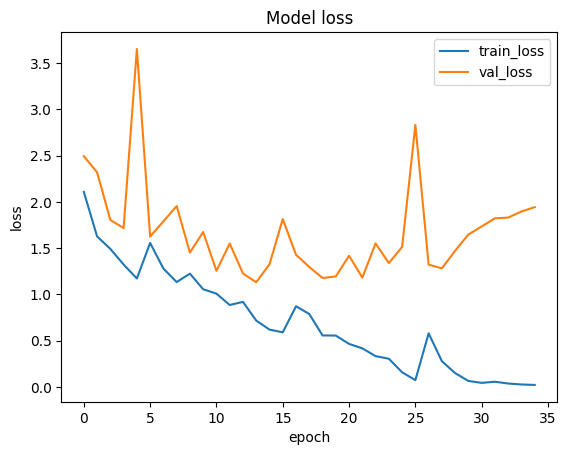

In [ ]:
plt.plot(history.history['loss'][:-1])
plt.plot(history.history['val_loss'][:-1])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

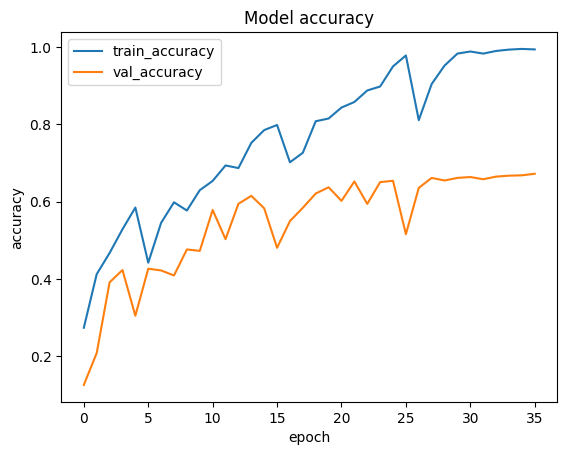

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

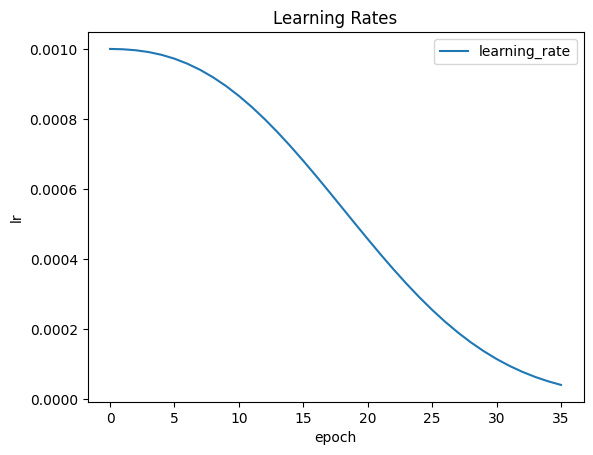

In [ ]:
plt.plot(history.history['lr'])
plt.title('Learning Rates')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['learning_rate'])
plt.show()

**Saving Model**

In [ ]:
model.save("model_weights", save_format = "tf")

**Plotting**

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,top_3_acc,val_loss,val_accuracy,val_top_3_acc,lr
0,2.108015,0.274141,0.597247,2.494193,0.126400,0.310933,0.001000
1,1.626665,0.412682,0.754424,2.319493,0.208800,0.483600,0.000999
2,1.491356,0.467388,0.796000,1.804098,0.391467,0.719333,0.000996
3,1.322317,0.528659,0.835859,1.716810,0.423333,0.750400,0.000991
4,1.171682,0.584847,0.868871,3.653437,0.305200,0.598400,0.000983


In [ ]:
def plot_training_stats(data):
  n = len(df)
  plt.figure(figsize=(10, 7))
  plt.subplot(121)
  plt.plot([i for i in range(1, n+1)], data['loss'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_loss'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Loss vs Epochs')
  plt.legend(["Loss", "Val_loss"])
  plt.subplot(122)
  plt.plot([i for i in range(1, n+1)], data['accuracy'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_accuracy'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title('Accuracy vs Epochs')
  plt.legend(["Accuracy", "Val_Accuracy"])

  plt.show()

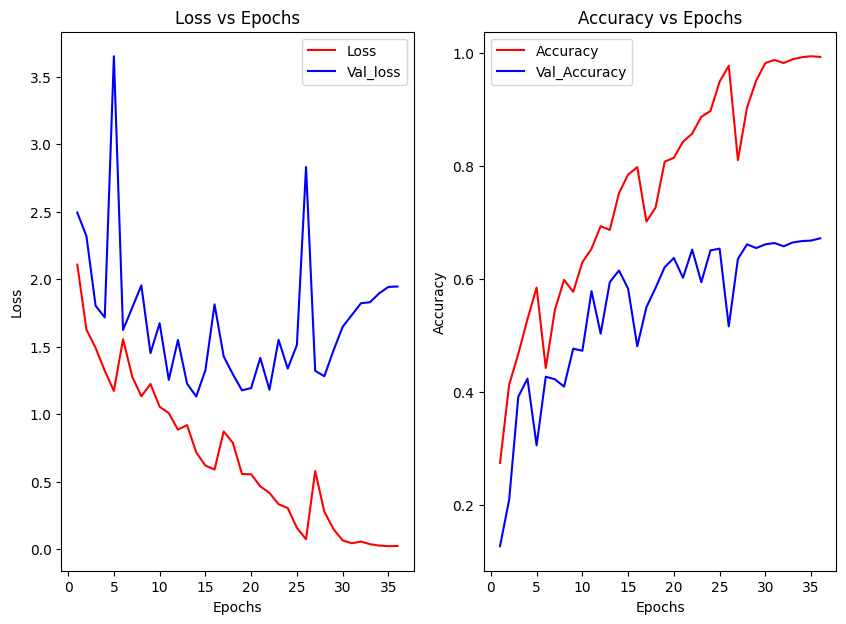

In [ ]:
plot_training_stats(df)

**Loading Pre-Trained Model**

In [ ]:
# model = get_model(tf.zeros((256, 32, 32, 3), dtype= float))
model.load_weights("best_weights")

**Evaluation**

In [ ]:
def evaluate(y_pred, y_true, encoder):
  corr = 0
  print(y_pred.shape, y_true.shape)
  for i in range(len(y_true)):
    if np.argmax(y_pred[i]) == y_true[i]:
      corr+=1
  return corr, corr / len(y_true)

In [ ]:
def eval_pipeline(X, y, enc, mdl):
  X_t = X / 255
  y_t = enc.transform(y)
  y_preds = mdl.predict(X_t)
  c, a = evaluate(y_preds, y, enc)
  print(f"Correct = {c} | Accuracy = {a}")
  return y_preds

In [ ]:
preds = eval_pipeline(X_t, y_t, enc, model)

313/313 [==============================] - 4s 9ms/step
(10000, 10) (10000, 1)
Correct = 6586 | Accuracy = 0.6586


In [ ]:
pred_lbls = np.argmax(preds, axis = 1)
n, m = len(labels), len(pred_lbls)
matrix = np.zeros((n, n))
for _ in range(m):
  matrix[pred_lbls[_]][y_t[_]] += 1

In [ ]:
pred_lbls

array([3, 1, 8, ..., 5, 1, 7])

Text(0.5, 1.0, 'Confusion Matrix')

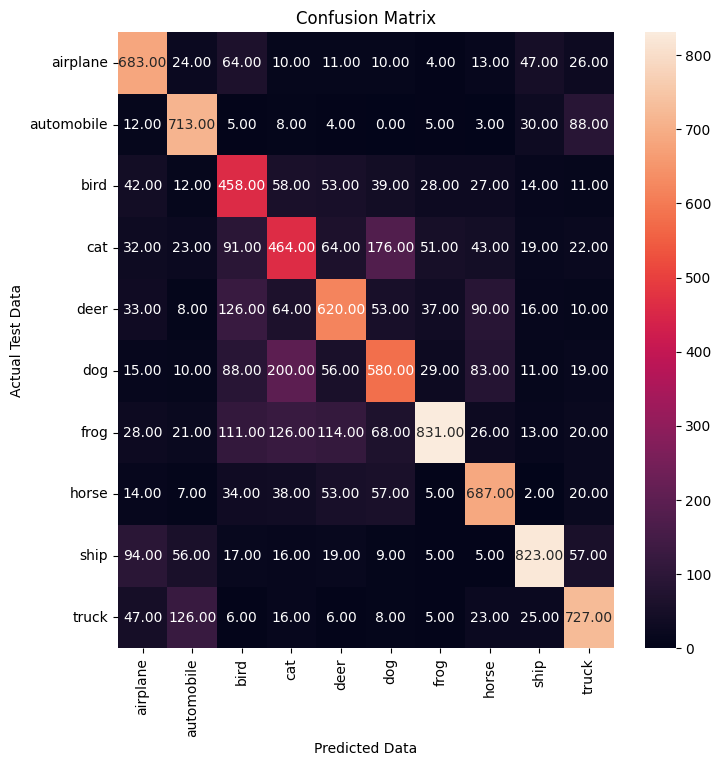

In [ ]:
import seaborn as sns
plt.figure(figsize= (8, 8))
sns.heatmap(matrix, annot=True, fmt= '.2f', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Data")
plt.ylabel("Actual Test Data")
plt.title("Confusion Matrix")

**Testing**

In [ ]:
def random_testing(X, y, lbl, y_preds= None):
  n = len(y)
  idx = np.random.randint(0, n)
  image, val = X[idx], int(y[idx][0])
  plt.imshow(image)
  s = f"Image number {idx+1} -> " + lbl[val]
  plt.title(s)

  if len(y_preds) != 0:
    pred_val = int(np.argmax(y_preds[idx]))
    print(f"Predicted Value = {lbl[pred_val]} | True Value = {lbl[val]} | Verdict = {True if pred_val == val else False}")

Predicted Value = cat | True Value = cat | Verdict = True


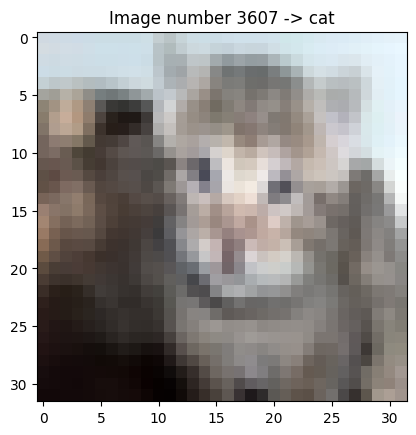

In [ ]:
random_testing(X_t, y_t, labels, preds)

In [ ]:
!zip -r best_weights.zip best_weights/

  adding: best_weights/ (stored 0%)
  adding: best_weights/assets/ (stored 0%)
  adding: best_weights/fingerprint.pb (stored 0%)
  adding: best_weights/keras_metadata.pb (deflated 95%)
  adding: best_weights/saved_model.pb (deflated 92%)
  adding: best_weights/variables/ (stored 0%)
  adding: best_weights/variables/variables.index (deflated 79%)
  adding: best_weights/variables/variables.data-00000-of-00001 (deflated 41%)
  adding: best_weights/.ipynb_checkpoints/ (stored 0%)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, top_k_accuracy_score, precision_score, recall_score, precision_recall_curve

In [ ]:
true_lbls = y_t.reshape(-1, )
print("F1 Score: ", f1_score(true_lbls, pred_lbls, average= "weighted"))
print("Accuracy Score: ", accuracy_score(true_lbls, pred_lbls))
print("Precision Score: ", precision_score(true_lbls, pred_lbls, average= "weighted"))
print("Recall Score: ", recall_score(true_lbls, pred_lbls, average= "weighted"))

F1 Score:  0.6572324007205789
Accuracy Score:  0.6586
Precision Score:  0.6637328058789261
Recall Score:  0.6586


In [ ]:
print("F1 Score: ", f1_score(true_lbls, pred_lbls, average= None))

F1 Score:  [0.72198732 0.7633833  0.52583238 0.4675063  0.60281964 0.55475849
 0.70483461 0.71674491 0.78343646 0.73102061]
